In [1]:
import numpy as np
import pandas as pd

In [38]:
DATA_DIR = "./data/"

In [39]:
df = pd.read_csv(DATA_DIR + "driving_log.csv")

In [40]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [54]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3)
df_train, df_valid = train_test_split(df_train, test_size=0.2)

def melt(df):
    lst_images, lst_steering = [], []
    for _, row in df.iterrows():
        # if row['steering']!=0:
        lst_images.append(row['center'])
        lst_steering.append(row['steering'])
        # lst_images.append(row['left'])
        # lst_steering.append(row['steering'] + 0.2)
        # lst_images.append(row['right'])
        # lst_steering.append(row['steering'] - 0.2)
    return pd.DataFrame({"center": lst_images, "steering": lst_steering})
        
df_train = melt(df_train)

In [55]:
import imageio
    
def generate_data(df, batch_size, flip_thresh=1.0):
    ix = df.index
    while True:
        ix = np.random.permutation(ix)
        for offset in range(0, df.shape[0], batch_size):
            ix_batch = ix[offset:offset+batch_size]
            flip_prob = np.random.rand(batch_size)
            lst_images, lst_labels = [], []
            for i, loc in enumerate(ix_batch):
                fpath = df.at[loc, 'center']
                img = imageio.imread(DATA_DIR + fpath.strip())
                # img = imageio.imread(fpath.strip())
                label = df.at[loc, 'steering']
                if flip_prob[i] > flip_thresh:
                    img = np.fliplr(img)
                    label *= -1
                lst_images.append(img)
                lst_labels.append(label)
            images = np.asarray(lst_images)
            labels = np.asarray(lst_labels)
            yield images, labels


In [56]:
batch_size = 32

generator_train = generate_data(df_train, batch_size, flip_thresh=0.5)
generator_valid = generate_data(df_valid, batch_size)
generator_test = generate_data(df_test, batch_size)

In [57]:
X_train, y_train = next(generator_train)

print(y_train.shape)
print(X_train.shape)

(32,)
(32, 160, 320, 3)


-0.0


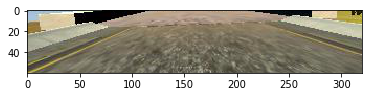

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

def clip(img):
    return img[70:-30,:,:]

def normalize(img):
    return img / 255. - 0.5


print(y_train[0])
plt.imshow(X_train[0]);
plt.imshow(clip(X_train[0]));

In [59]:
from keras.models import Sequential
from keras.layers import Cropping2D, Lambda, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

In [60]:
model = Sequential()
model.add(Lambda(normalize, input_shape=(160, 320, 3)))
model.add(Cropping2D(((70,30), (0,0))))
model.add(Conv2D(6, 5, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(10, 5, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, 5, activation='relu', input_shape=(160, 320, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [61]:
# model.save('model2.h5')

In [62]:
model.load_weights('model2.h5')

In [63]:
model.fit_generator(generator_train, samples_per_epoch=df_train.shape[0], nb_epoch=20,
                    validation_data=generator_valid, nb_val_samples=df_valid.shape[0])

Epoch 1/20
4500/4500 [==============================] - 123s - loss: 0.0132 - val_loss: 0.0122
Epoch 2/20
4500/4500 [==============================] - 176s - loss: 0.0110 - val_loss: 0.0138
Epoch 3/20
4500/4500 [==============================] - 157s - loss: 0.0109 - val_loss: 0.0123
Epoch 4/20
4500/4500 [==============================] - 142s - loss: 0.0107 - val_loss: 0.0112
Epoch 5/20
4500/4500 [==============================] - 171s - loss: 0.0103 - val_loss: 0.0106
Epoch 6/20
4500/4500 [==============================] - 179s - loss: 0.0104 - val_loss: 0.0120
Epoch 7/20
4500/4500 [==============================] - 187s - loss: 0.0102 - val_loss: 0.0123
Epoch 8/20
4500/4500 [==============================] - 132s - loss: 0.0101 - val_loss: 0.0120
Epoch 9/20
4500/4500 [==============================] - 149s - loss: 0.0099 - val_loss: 0.0112
Epoch 10/20
4500/4500 [==============================] - 179s - loss: 0.0098 - val_loss: 0.0119
Epoch 11/20
4500/4500 [==========================

In [64]:
model.save('model3.h5')